<div class='alert alert-block alert-info'>
<b>Note:</b> This nb was used for explorative DEV of the trx data load functions (sales and fees fact tables) and feature tools application (see section 4!)

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-Periods-and-Load-Population" data-toc-modified-id="Define-Periods-and-Load-Population-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define Periods and Load Population</a></span><ul class="toc-item"><li><span><a href="#Date-Considerations" data-toc-modified-id="Date-Considerations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Date Considerations</a></span></li></ul></li><li><span><a href="#Basic-Data-Load" data-toc-modified-id="Basic-Data-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Data Load</a></span></li><li><span><a href="#DEV-load_facts" data-toc-modified-id="DEV-load_facts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DEV load_facts</a></span><ul class="toc-item"><li><span><a href="#Sales-Fact" data-toc-modified-id="Sales-Fact-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Sales Fact</a></span></li><li><span><a href="#Fees-Fact" data-toc-modified-id="Fees-Fact-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fees Fact</a></span></li></ul></li><li><span><a href="#DEV-featurestools" data-toc-modified-id="DEV-featurestools-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DEV featurestools</a></span><ul class="toc-item"><li><span><a href="#Sales_fact-only" data-toc-modified-id="Sales_fact-only-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sales_fact only</a></span></li><li><span><a href="#Add-Fees-Fact-to-Entity-Set" data-toc-modified-id="Add-Fees-Fact-to-Entity-Set-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Add Fees Fact to Entity Set</a></span></li><li><span><a href="#Experiment-with-different-features" data-toc-modified-id="Experiment-with-different-features-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Experiment with different features</a></span><ul class="toc-item"><li><span><a href="#Try-OHE-Encoding-of-categorical-variables" data-toc-modified-id="Try-OHE-Encoding-of-categorical-variables-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Try OHE Encoding of categorical variables</a></span></li><li><span><a href="#Adding-&quot;interesting-values&quot;-instead-of-OHE" data-toc-modified-id="Adding-&quot;interesting-values&quot;-instead-of-OHE-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Adding "interesting values" instead of OHE</a></span></li></ul></li></ul></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Sales-Fact:-Categorical-Values" data-toc-modified-id="Sales-Fact:-Categorical-Values-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Sales Fact: Categorical Values</a></span></li><li><span><a href="#Fees-Fact:-Bewegungstypen-und-Bewegungsgründe-seit-2019" data-toc-modified-id="Fees-Fact:-Bewegungstypen-und-Bewegungsgründe-seit-2019-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Fees Fact: Bewegungstypen und Bewegungsgründe seit 2019</a></span></li><li><span><a href="#Primitives-List-from-FeatureTools" data-toc-modified-id="Primitives-List-from-FeatureTools-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Primitives List from FeatureTools</a></span></li></ul></li></ul></div>

**Results**

**1) Different Feature Load**

Sales_Fact & Fees_Fact have been tweaked to return different categorical features compared to the last run. While the changes to sales_fact features are more technical, for fees_fact the 'bewegungstyp' and 'bewegungsgrund' have been merged into more speaking categories:

```sql
       , CASE WHEN ff.bewegungstyp_id IN (41, 42, 43, 44) THEN 'mahnung' 
              WHEN ff.bewegungsgrund_id IN ('FRW', 'WSZ', 'ETA') THEN 'fremdw'
              WHEN (ff.bewegungsgrund_id = 'ZIN' OR ff.bewegungstyp_id = 31) THEN 'zins'
              ELSE 'divers' END AS 'bewegungstyp'
```

**2) New Use of "interesting values"**

That the categorical features can fully be exploited, the most relevant of them should be declares as "interesting features" in the ft pipeline, so they are treated on their own. (In the past we only had them in form of MODE and NUM_UNIQUE features.)

<br>**-> For the moment I calculate about 46 features from Sales_Fact and Fees_Fact using FT**


<br>**Open Questions concerning the features:**
- Should we also add transactiontype values to the "interesting values"? (I have not yet)
- Is it ok, that I have removed most trans_primitives?

In [1]:
import sys
from datetime import date, datetime, timedelta
from pathlib import Path

import bcag
import numpy as np
import pandas as pd
from bcag.sql_utils import execute_sql_query
from sqlalchemy.engine.base import Engine

In [2]:
sys.path.append("..")
from churn21.data import dates as utils_dt, load as utils_load

In [3]:
%load_ext autoreload
%autoreload 1
%aimport churn21.data.dates, churn21.data.load

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

In [4]:
sys.path.append(str(Path.cwd().parent))
from churn21.data import dates as utils_dt, load as utils_ld

## Define Periods and Load Population

###  Date Considerations

- required dates
    - first considered date for observation period
    - cut-off date
    - last considered date for label period
    
- lookback period: 13 months; this allows us to
    - compute trx-based features for 12 months up to cut off date
    - separate comparison of month -13 to  month -1 to create a trend (last observed month vs the same month a year ago)

In [5]:
dt_params = dict({
    "last_cut_off_date_train": date(2020, 10, 31),
    "first_cut_off_date_train": date(2020, 7, 31),
    "lookback_period_months": 13,
    "label_period_months": 3,
    "n_months_considered_training": 6
})
l_dates_train, l_dates_test = utils_dt.create_dateinfo(dt_params)

In [6]:
l_dates_train

[{'dt_cut_off': datetime.date(2020, 7, 31),
  'dt_obs_first_considered': datetime.date(2019, 7, 1),
  'dt_label_last_considered': datetime.date(2020, 10, 31)},
 {'dt_cut_off': datetime.date(2020, 8, 31),
  'dt_obs_first_considered': datetime.date(2019, 8, 1),
  'dt_label_last_considered': datetime.date(2020, 11, 30)},
 {'dt_cut_off': datetime.date(2020, 9, 30),
  'dt_obs_first_considered': datetime.date(2019, 9, 1),
  'dt_label_last_considered': datetime.date(2020, 12, 31)},
 {'dt_cut_off': datetime.date(2020, 10, 31),
  'dt_obs_first_considered': datetime.date(2019, 10, 1),
  'dt_label_last_considered': datetime.date(2021, 1, 31)}]

In [7]:
l_dates_test

[{'dt_cut_off': datetime.date(2021, 1, 31),
  'dt_obs_first_considered': datetime.date(2020, 1, 1),
  'dt_label_last_considered': datetime.date(2021, 4, 30)}]

## Basic Data Load

In [8]:
engine = bcag.connect("jemas", "prod", "jemas_temp")

In [10]:
df_population = utils_ld.load_population(engine)
df_population = utils_ld.filter_population(df_population, pd.to_datetime("2020-12-31"))

assert df_population.duplicated().sum() == 0

df_population.shape
df_population.head()

(129629, 1)

,konto_lauf_id
0,51
1,129
2,157
3,235
4,503


## DEV load_facts

Ich lade hier einige random konto_lauf_id aus der churn21_population tabelle (siehe prep CTE in der Query).

In [11]:
# Little helper to reduce memory impact when working with feature tools

def downcast_dtypes(df: pd.DataFrame, verbose=True) -> pd.DataFrame:
    """Return a copy of a Pandas DataFrame with reduced
    Memory Usage. ATTENTION: Only 'object' dtypes are considered 
    for conversion to 'category'.
    """
    if verbose:
        print(
            f" Original memory usage "
            f"{df.memory_usage(deep=True).sum() / (1024**2):,.2f} MB"
        )
    
    df=df.copy()
    
    for col in df.columns:
        col_type = str(df[col].dtype)
        col_items = df[col].count()
        col_unique_itmes = df[col].nunique()

        if col_type == 'object' and col_unique_itmes < col_items:
                df[col] = df[col].astype('category')
        if col_type.startswith("int"):
                df[col] = pd.to_numeric(df[col], downcast='integer')
        if col_type.startswith("float"):
                df[col] = pd.to_numeric(df[col], downcast='float')
                
    if verbose:
        print(
            f" New memory usage "
            f"{df.memory_usage(deep=True).sum() / (1024**2):,.2f} MB"
        )
    
    return df

### Sales Fact

In [12]:
def load_sales_fact(
    cut_off_date: date, from_date: date, engine: Engine
) -> pd.DataFrame:
    """load relevant observations from the db table 'jemas_base.dbo.Sales_Fact'
    given start and end date and the population

    Parameters
    ----------
    cut_off_date : date
        cut-off date separating observation period from label period
    from_date :  date
        first date of observation period
    engine : Engine
        jemas connection

    Returns
    -------
    pd.DataFrame
        [description]
    """
    # TODO For testing I quite randomly select a few customers only in the query
    query = (f"""
        WITH prep AS (
        SELECT TOP (100) konto_lauf_id
          FROM jemas_temp.thm.churn21_population
         WHERE jamo > 202008
)

        SELECT prep.*
            , sf.betrag
            , sf.kauf_datum
            , sf.transaction_type_id           -- NEUES FEATURE, ersetzt 'eci_id', 'is_contactless', 'is_mobile_payment'
            , mcc.mcg AS mcg_id                -- NEUES FEATURE, ersetzt mcc_id
            , sf.transaktionsart_id_korr       -- NEUES FEATURE
        FROM prep
        LEFT JOIN jemas_base.dbo.Sales_Fact AS sf
          ON sf.konto_lauf_id = prep.konto_lauf_id
        JOIN jemas_base.dbo.v_mcc AS mcc
          ON mcc.mcc_id = sf.mcc_id
       WHERE sf.erfassung_datum <= '{cut_off_date}'
         AND sf.erfassung_datum >= '{from_date}'
         AND sf.ist_umsatz = 1
         AND sf.ist_trx = 1
         AND sf.betrag > 0
         ORDER BY prep.konto_lauf_id;
       """
    )
    df_sales_fact = pd.read_sql(query, engine)
    
    # Add "primary key" for feature tools
    df_sales_fact["rwn"] = np.arange(len(df_sales_fact))
    return df_sales_fact

In [13]:
df_sales_fact = load_sales_fact(date(2020, 12, 31), date(2020, 1, 1), engine)
df_sales_fact = downcast_dtypes(df_sales_fact)

 Original memory usage 0.40 MB
 New memory usage 0.07 MB


In [14]:
df_sales_fact.shape
df_sales_fact["konto_lauf_id"].nunique()
df_sales_fact.head(2)

(3631, 7)

65

,konto_lauf_id,betrag,kauf_datum,transaction_type_id,mcg_id,transaktionsart_id_korr,rwn
0,84634,12.00,2020-01-23 09:54:00,1,BC Diverse,0,0
1,84634,114.00,2020-02-06 17:03:00,1,BC Diverse,0,1


<AxesSubplot:>

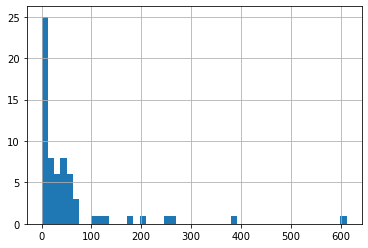

In [15]:
df_sales_fact.groupby("konto_lauf_id")["betrag"].count().hist(bins=50)

### Fees Fact

In [16]:
def load_fees_fact(
    cut_off_date: date, from_date: date, engine: Engine
) -> pd.DataFrame:
    """load relevant observations from the db table 'jemas_base.dbo.fees_Fact'
    given start and end date and the population

    Parameters
    ----------
    cut_off_date : date
        cut-off date separating observation period from label period
    from_date :  date
        first date of observation period
    engine : Engine
        jemas connection

    Returns
    -------
    pd.DataFrame
        [description]
    """
    # TODO For testing I quite randomly select a few customers only in the query
    query = (f"""
        WITH prep AS (
        SELECT TOP (100) konto_lauf_id
          FROM jemas_temp.thm.churn21_population
         WHERE jamo > 202008
)

        SELECT prep.konto_lauf_id
        , ff.betrag
        , ff.kauf_datum
       , CASE WHEN ff.bewegungstyp_id IN (41, 42, 43, 44) THEN 'mahnung' 
              WHEN ff.bewegungsgrund_id IN ('FRW', 'WSZ', 'ETA') THEN 'fremdw'
              WHEN (ff.bewegungsgrund_id = 'ZIN' OR ff.bewegungstyp_id = 31) THEN 'zins'
              ELSE 'divers' END AS 'bewegungstyp'
        FROM prep
        LEFT JOIN jemas_base.dbo.Fees_Fact as ff
            on ff.konto_lauf_id = prep.konto_lauf_id
        WHERE erfassung_datum < '{cut_off_date}'
          AND erfassung_datum >= '{from_date}'
          AND bewegungstyp_id != 11
          AND NOT ff.bewegungsgrund_id IN ('JGT', 'JGE', 'JGR')
          AND ff.betrag > 0
        ORDER BY prep.konto_lauf_id;
       """
    )
    df_fees_fact = pd.read_sql(query, engine)
    
    # Add "primary key" for feature tools
    df_fees_fact["rwn"] = np.arange(len(df_fees_fact))
    return df_fees_fact

In [17]:
df_fees_fact = load_fees_fact(date(2020, 12, 31), date(2020, 1, 1), engine)
df_fees_fact = downcast_dtypes(df_fees_fact)

 Original memory usage 0.29 MB
 New memory usage 0.06 MB


In [18]:
df_fees_fact.shape
df_fees_fact["konto_lauf_id"].nunique()
df_fees_fact.head(2)

(3350, 5)

88

,konto_lauf_id,betrag,kauf_datum,bewegungstyp,rwn
0,117654,2.00,2020-01-18 23:59:00,divers,0
1,117654,2.00,2020-02-15 23:59:00,divers,1


In [19]:
df_fees_fact = df_fees_fact[df_fees_fact["konto_lauf_id"].isin(df_sales_fact["konto_lauf_id"].unique())]
df_fees_fact["konto_lauf_id"].nunique()

62

<AxesSubplot:>

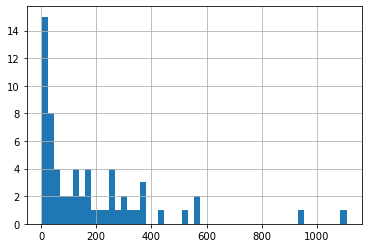

In [20]:
df_fees_fact.groupby("konto_lauf_id")["betrag"].sum().hist(bins=50)

## DEV featurestools 

In [21]:
import featuretools as ft

In [22]:
# For DEV only, create a pop df based on the id's in df_sales_fact (no variable columns)
df_pop_short = pd.DataFrame(df_sales_fact["konto_lauf_id"].unique(), columns=["konto_lauf_id"])

df_pop_short.shape

(65, 1)

In [23]:
# For DEV only, create a cut-off-times df based on the id's in df_pop_short
df_cutoff = df_pop_short.copy()
df_cutoff["time"] = datetime(year=2021, month=1, day=1)

df_cutoff.shape
df_cutoff.head(2)

(65, 2)

,konto_lauf_id,time
0,84634,2021-01-01
1,117654,2021-01-01


### Sales_fact only

In [25]:
# Initialize entity_set
es = ft.EntitySet(id="churn21")

# Add entities
es = es.entity_from_dataframe(
    entity_id="sales_fact",
    dataframe=df_sales_fact,
    index="rwn",
    time_index="kauf_datum",
    variable_types={
        "transaction_type_id": ft.variable_types.Categorical,
        "mcg_id": ft.variable_types.Categorical,
        "transaktionsart_id_korr": ft.variable_types.Categorical,
    }
)

es = es.entity_from_dataframe(
    entity_id="population",
    dataframe=df_pop_short,
    index="konto_lauf_id",
)

# Add relationships
rs_population_sales_fact = ft.Relationship(
    es["population"]["konto_lauf_id"], es["sales_fact"]["konto_lauf_id"]
)
es = es.add_relationship(rs_population_sales_fact)

# Check results
es

Entityset: churn21
  Entities:
    sales_fact [Rows: 3631, Columns: 7]
    population [Rows: 65, Columns: 1]
  Relationships:
    sales_fact.konto_lauf_id -> population.konto_lauf_id

In [27]:
# Create feature set with basic settings
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_entity="population",
)

# Check results
len(feature_defs)
feature_defs

21

[<Feature: COUNT(sales_fact)>,
 <Feature: MAX(sales_fact.betrag)>,
 <Feature: MEAN(sales_fact.betrag)>,
 <Feature: MIN(sales_fact.betrag)>,
 <Feature: MODE(sales_fact.mcg_id)>,
 <Feature: MODE(sales_fact.transaction_type_id)>,
 <Feature: MODE(sales_fact.transaktionsart_id_korr)>,
 <Feature: NUM_UNIQUE(sales_fact.mcg_id)>,
 <Feature: NUM_UNIQUE(sales_fact.transaction_type_id)>,
 <Feature: NUM_UNIQUE(sales_fact.transaktionsart_id_korr)>,
 <Feature: SKEW(sales_fact.betrag)>,
 <Feature: STD(sales_fact.betrag)>,
 <Feature: SUM(sales_fact.betrag)>,
 <Feature: MODE(sales_fact.DAY(kauf_datum))>,
 <Feature: MODE(sales_fact.MONTH(kauf_datum))>,
 <Feature: MODE(sales_fact.WEEKDAY(kauf_datum))>,
 <Feature: MODE(sales_fact.YEAR(kauf_datum))>,
 <Feature: NUM_UNIQUE(sales_fact.DAY(kauf_datum))>,
 <Feature: NUM_UNIQUE(sales_fact.MONTH(kauf_datum))>,
 <Feature: NUM_UNIQUE(sales_fact.WEEKDAY(kauf_datum))>,
 <Feature: NUM_UNIQUE(sales_fact.YEAR(kauf_datum))>]

**Evaluation of Sales Fact Features**:

My proposals:
- Do away with MODE for datetime (4 features)
- Do away with NUM_UNIQUE for YEAR, WEEKDAY, DAY, but keep MONTH (?)
- MODE(mcg_id) might be uninteresting due to distribution:

In [28]:
# Most customers have "other"
feature_matrix["MODE(sales_fact.mcg_id)"].value_counts()

OTHER PURCHASE                52
BC Diverse                     4
RESTAURANT                     4
ATM CASH                       3
RISKY PURCHASE                 1
BC Jelmoli House of Brands     1
Name: MODE(sales_fact.mcg_id), dtype: int64

In [29]:
# This seems more promising
feature_matrix["NUM_UNIQUE(sales_fact.mcg_id)"].value_counts()

2    13
5    13
4    11
1     9
3     8
6     6
8     3
7     1
9     1
Name: NUM_UNIQUE(sales_fact.mcg_id), dtype: int64

### Add Fees Fact to Entity Set

In [30]:
# Add entity
es = es.entity_from_dataframe(
    entity_id="fees_fact",
    dataframe=df_fees_fact,
    index="rwn",
    time_index="kauf_datum",
    variable_types={
        "bewegungstyp": ft.variable_types.Categorical,
    }
)

# Add relationships
rs_population_fees_fact = ft.Relationship(
    es["population"]["konto_lauf_id"], es["fees_fact"]["konto_lauf_id"]
)
es = es.add_relationship(rs_population_fees_fact)

# Check results
es

Entityset: churn21
  Entities:
    sales_fact [Rows: 3631, Columns: 7]
    population [Rows: 65, Columns: 1]
    fees_fact [Rows: 3124, Columns: 5]
  Relationships:
    sales_fact.konto_lauf_id -> population.konto_lauf_id
    fees_fact.konto_lauf_id -> population.konto_lauf_id

In [31]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_entity="population",
)

# Check results
len(feature_defs)
feature_defs

38

**Evaluation of Fees Fact Features**:

My proposals:
- Do away with MODE for datetime (2 features)


### Experiment with different features

In [32]:
ft_to_drop = [
    "MODE(sales_fact.MONTH(kauf_datum))",
    "MODE(fees_fact.MONTH(kauf_datum))",
#    "MODE(sales_fact(mcg_id))",
]

In [33]:
# Create feature set, based on the primitives from the old chrun model

feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_entity="population",
        verbose=True,
        drop_exact=ft_to_drop,
        agg_primitives=[
            "sum",
            "std",
            "max",
            "skew",
            "min",
            "mean",
            "count",
#             "percent_true",           # we have no booleans in the input features
            "num_unique",
            "mode",
            "avg_time_between",
            "trend",
            "time_since_last",
#             "n_most_common",          # not in old model, just for exploration, not necessary
        ],
        trans_primitives=[
            "month",                    # ATTENTION: I have removed day, year and weekday
#             "subtract_numeric",       # just for exploration  --> 306 features
#             'percentile',             # just for exploration  --> 68 features
#             'isin',                   # just for exploration  --> 69 features -- PERCENT TRUE IS IN (NONE)
#             'cum_mean',               # not in old model, just for exploration
#             'time_since_previous'     # not in old model, just for exploration, not necessary
        ], 
        n_jobs=1,
    )

Built 30 features
Elapsed: 00:01 | Progress: 100%|██████████


#### Try OHE Encoding of categorical variables

In [34]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)

In [35]:
len(features_enc)
features_enc

46

[<Feature: AVG_TIME_BETWEEN(sales_fact.kauf_datum)>,
 <Feature: COUNT(sales_fact)>,
 <Feature: MAX(sales_fact.betrag)>,
 <Feature: MEAN(sales_fact.betrag)>,
 <Feature: MIN(sales_fact.betrag)>,
 <Feature: MODE(sales_fact.mcg_id) = OTHER PURCHASE>,
 <Feature: MODE(sales_fact.mcg_id) = RESTAURANT>,
 <Feature: MODE(sales_fact.mcg_id) = BC Diverse>,
 <Feature: MODE(sales_fact.mcg_id) = ATM CASH>,
 <Feature: MODE(sales_fact.mcg_id) = RISKY PURCHASE>,
 <Feature: MODE(sales_fact.mcg_id) = BC Jelmoli House of Brands>,
 <Feature: MODE(sales_fact.mcg_id) is unknown>,
 <Feature: MODE(sales_fact.transaction_type_id) = 1>,
 <Feature: MODE(sales_fact.transaction_type_id) = 2>,
 <Feature: MODE(sales_fact.transaction_type_id) = 3>,
 <Feature: MODE(sales_fact.transaction_type_id) = 6>,
 <Feature: MODE(sales_fact.transaction_type_id) = 4>,
 <Feature: MODE(sales_fact.transaction_type_id) is unknown>,
 <Feature: MODE(sales_fact.transaktionsart_id_korr) = 2>,
 <Feature: MODE(sales_fact.transaktionsart_id_ko

In [36]:
feature_matrix_enc.head(5)

,AVG_TIME_BETWEEN(sales_fact.kauf_datum),COUNT(sales_fact),MAX(sales_fact.betrag),MEAN(sales_fact.betrag),MIN(sales_fact.betrag),MODE(sales_fact.mcg_id) = OTHER PURCHASE,MODE(sales_fact.mcg_id) = RESTAURANT,MODE(sales_fact.mcg_id) = BC Diverse,MODE(sales_fact.mcg_id) = ATM CASH,MODE(sales_fact.mcg_id) = RISKY PURCHASE,MODE(sales_fact.mcg_id) = BC Jelmoli House of Brands,MODE(sales_fact.mcg_id) is unknown,MODE(sales_fact.transaction_type_id) = 1,MODE(sales_fact.transaction_type_id) = 2,MODE(sales_fact.transaction_type_id) = 3,...,MAX(fees_fact.betrag),MEAN(fees_fact.betrag),MIN(fees_fact.betrag),MODE(fees_fact.bewegungstyp) = zins,MODE(fees_fact.bewegungstyp) = fremdw,MODE(fees_fact.bewegungstyp) = divers,MODE(fees_fact.bewegungstyp) is unknown,NUM_UNIQUE(fees_fact.bewegungstyp),SKEW(fees_fact.betrag),STD(fees_fact.betrag),SUM(fees_fact.betrag),TIME_SINCE_LAST(fees_fact.kauf_datum),"TREND(fees_fact.betrag, kauf_datum)",NUM_UNIQUE(sales_fact.MONTH(kauf_datum)),NUM_UNIQUE(fees_fact.MONTH(kauf_datum))
konto_lauf_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84634,"688,560.00",4,114.00,84.50,12.00,False,False,True,False,False,False,False,True,False,False,...,NaN,NaN,NaN,False,False,False,True,NaN,NaN,NaN,0.00,NaN,NaN,2,NaN
117654,"485,822.95",62,899.00,114.89,9.90,False,True,False,False,False,False,False,False,False,True,...,2.00,2.00,2.00,False,False,True,False,1.00,0.00,0.00,24.00,"12,992,799.95",0.00,11,11.00
207389,"86,400.00",16,77.05,34.27,6.85,True,False,False,False,False,False,False,False,False,True,...,NaN,NaN,NaN,False,False,False,True,NaN,NaN,NaN,0.00,NaN,NaN,1,NaN
298048,"1,419,291.00",21,449.95,134.80,34.90,True,False,False,False,False,False,False,False,False,True,...,2.00,2.00,2.00,False,False,True,False,1.00,0.00,0.00,20.00,"13,597,599.95",0.00,9,9.00
328419,"502,325.58",44,176.00,49.19,4.50,True,False,False,False,False,False,False,False,False,True,...,1.19,0.68,0.02,False,True,False,False,2.00,-0.37,0.41,9.53,"31,741,599.95",0.00,9,4.00


**Findings**: Does not help much.

#### Adding "interesting values" instead of OHE

In [38]:
# Adding interesting values (-> where_primitives)

es["fees_fact"]["bewegungstyp"].interesting_values = ["mahnung", "fremdw", "zins"]
es["sales_fact"]["transaktionsart_id_korr"].interesting_values = [0]  # BC closed loop

feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_entity="population",
        verbose=True,
        drop_exact=ft_to_drop,
        cutoff_time = df_cutoff,     # NEW - it would be easier to pass a dt value: datetime(2020, 12, 31)
        agg_primitives=[
            "sum",
            "std",
            "max",
            "skew",
            "min",
            "mean",
            "count",
            "num_unique",
            "mode",
            "avg_time_between",
            "trend",
            "time_since_last",
        ],
        trans_primitives=[
            "month",
        ], 
        where_primitives=["sum", "count", "mean", "trend"],
        n_jobs=1,                 
    )

Built 46 features
Elapsed: 00:01 | Progress: 100%|██████████


In [39]:
len(feature_defs)
feature_defs

46

[<Feature: AVG_TIME_BETWEEN(sales_fact.kauf_datum)>,
 <Feature: COUNT(sales_fact)>,
 <Feature: MAX(sales_fact.betrag)>,
 <Feature: MEAN(sales_fact.betrag)>,
 <Feature: MIN(sales_fact.betrag)>,
 <Feature: MODE(sales_fact.mcg_id)>,
 <Feature: MODE(sales_fact.transaction_type_id)>,
 <Feature: MODE(sales_fact.transaktionsart_id_korr)>,
 <Feature: NUM_UNIQUE(sales_fact.mcg_id)>,
 <Feature: NUM_UNIQUE(sales_fact.transaction_type_id)>,
 <Feature: NUM_UNIQUE(sales_fact.transaktionsart_id_korr)>,
 <Feature: SKEW(sales_fact.betrag)>,
 <Feature: STD(sales_fact.betrag)>,
 <Feature: SUM(sales_fact.betrag)>,
 <Feature: TIME_SINCE_LAST(sales_fact.kauf_datum)>,
 <Feature: TREND(sales_fact.betrag, kauf_datum)>,
 <Feature: AVG_TIME_BETWEEN(fees_fact.kauf_datum)>,
 <Feature: COUNT(fees_fact)>,
 <Feature: MAX(fees_fact.betrag)>,
 <Feature: MEAN(fees_fact.betrag)>,
 <Feature: MIN(fees_fact.betrag)>,
 <Feature: MODE(fees_fact.bewegungstyp)>,
 <Feature: NUM_UNIQUE(fees_fact.bewegungstyp)>,
 <Feature: SKEW(fe

In [40]:
feature_matrix.head(2)

,AVG_TIME_BETWEEN(sales_fact.kauf_datum),COUNT(sales_fact),MAX(sales_fact.betrag),MEAN(sales_fact.betrag),MIN(sales_fact.betrag),MODE(sales_fact.mcg_id),MODE(sales_fact.transaction_type_id),MODE(sales_fact.transaktionsart_id_korr),NUM_UNIQUE(sales_fact.mcg_id),NUM_UNIQUE(sales_fact.transaction_type_id),NUM_UNIQUE(sales_fact.transaktionsart_id_korr),SKEW(sales_fact.betrag),STD(sales_fact.betrag),SUM(sales_fact.betrag),TIME_SINCE_LAST(sales_fact.kauf_datum),...,SUM(sales_fact.betrag WHERE transaktionsart_id_korr = 0),"TREND(sales_fact.betrag, kauf_datum WHERE transaktionsart_id_korr = 0)",COUNT(fees_fact WHERE bewegungstyp = zins),COUNT(fees_fact WHERE bewegungstyp = fremdw),COUNT(fees_fact WHERE bewegungstyp = mahnung),MEAN(fees_fact.betrag WHERE bewegungstyp = zins),MEAN(fees_fact.betrag WHERE bewegungstyp = fremdw),MEAN(fees_fact.betrag WHERE bewegungstyp = mahnung),NUM_UNIQUE(fees_fact.MONTH(kauf_datum)),SUM(fees_fact.betrag WHERE bewegungstyp = zins),SUM(fees_fact.betrag WHERE bewegungstyp = fremdw),SUM(fees_fact.betrag WHERE bewegungstyp = mahnung),"TREND(fees_fact.betrag, kauf_datum WHERE bewegungstyp = zins)","TREND(fees_fact.betrag, kauf_datum WHERE bewegungstyp = fremdw)","TREND(fees_fact.betrag, kauf_datum WHERE bewegungstyp = mahnung)"
konto_lauf_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84634,"688,560.00",4,114.00,84.50,12.00,BC Diverse,1,0,1,1,1,-1.96,48.48,338.00,"27,620,280.00",...,338.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN
117654,"485,822.95",62,899.00,114.89,9.90,RESTAURANT,3,2,5,2,2,2.93,162.24,"7,123.10","1,036,800.00",...,908.90,NaN,0.00,0.00,0.00,NaN,NaN,NaN,11.00,0.00,0.00,0.00,NaN,NaN,NaN


In [41]:
feature_matrix["TIME_SINCE_LAST(sales_fact.kauf_datum)"].head(5)

konto_lauf_id
84634    27,620,280.00
117654    1,036,800.00
207389    8,812,800.00
298048    1,854,180.00
328419    8,035,200.00
Name: TIME_SINCE_LAST(sales_fact.kauf_datum), dtype: float64

This are the results without passing a cutoff date .... (one year is about 30 Mio MS)

```
    konto_lauf_id
    561659   37,719,230.97
    563651   13,786,430.97
    587382   24,845,630.97
    618498   36,682,430.97
    642932   26,746,430.97
    Name: TIME_SINCE_LAST(sales_fact.kauf_datum), dtype: float64
```

**Findings:** 
- Without using interesting values you probably underuse the categorical variables (at least the interesting ones)
- Do not forget to pass a cut_off_date - if you don't the time_since_last returns a wrong value

## Appendix

### Sales Fact: EDA of Categorical Values

In [ ]:
query = (f"""
    SELECT 
        transaction_type_id,
        transaction_type
      FROM jemas_base.dbo.transaction_type_help
    """
)

pd.read_sql(query, engine)

In [ ]:
query = (f"""
    SELECT 
        transaktionsart_id_korr,
        transaktionsart
      FROM jemas_base.dbo.transaktionsart_id_korr_help
    """
)

pd.read_sql(query, engine)

### Fees Fact: Bewegungstypen und Bewegungsgründe seit 2019

In [ ]:
query = (f"""
    SELECT ff. bewegungstyp_id, bt.bewegungstyp
        , COUNT(ff.betrag) AS count
        , SUM(ff.betrag) AS sum
      FROM jemas_base.dbo.Fees_Fact AS ff
      JOIN jemas_base.dbo.Bewegungstyp AS bt
        ON bt.bewegungstyp_id = ff.bewegungstyp_id
     WHERE ff.erfassung_datum >= '2019-01-01'
       AND NOT ff.bewegungsgrund_id IN ('JGT', 'JGE', 'JGR')
       AND ff.betrag > 0
    GROUP BY ff.bewegungstyp_id, bt.bewegungstyp
    ORDER BY SUM(ff.betrag) DESC
    """
         
)

df_bt = pd.read_sql(query, engine)

In [ ]:
df_bt

**Notes:** Mahngebühren (41, 42, 43, 44) könnten als eigene Gruppe zusammengefasst und hervorgehoben werden.

In [ ]:
query = (f"""
        SELECT ff.bewegungsgrund_id, bg.bewegungsgrund
            , COUNT(ff.betrag) AS count
            , SUM(ff.betrag) AS sum
        FROM jemas_base.dbo.Fees_Fact AS ff
          JOIN jemas_base.dbo.Bewegungsgrund AS bg
            ON bg.bewegungsgrund_id = ff.bewegungsgrund_id
        WHERE ff.erfassung_datum >= '2019-01-01'
          AND ff.bewegungstyp_id = 61
          AND NOT ff.bewegungsgrund_id IN ('JGT', 'JGE', 'JGR')
          AND ff.betrag > 0
        GROUP BY ff.bewegungsgrund_id, bg.bewegungsgrund
        ORDER BY SUM(ff.betrag) DESC
    """
)

df_bg_61 = pd.read_sql(query, engine)

In [ ]:
df_bg_61

**Notes:** Fremdwährungs- / Auslandgebühren (FRW, WSZ, ETA)  könnten als eigene Gruppe zusammengefasst und hervorgehoben werden.

In [ ]:
query = (f"""
        SELECT ff.bewegungsgrund_id, bg.bewegungsgrund
            , COUNT(ff.betrag) AS count
            , SUM(ff.betrag) AS sum
        FROM jemas_base.dbo.Fees_Fact AS ff
          JOIN jemas_base.dbo.Bewegungsgrund AS bg
            ON bg.bewegungsgrund_id = ff.bewegungsgrund_id
        WHERE ff.erfassung_datum >= '2019-01-01'
          AND ff.bewegungstyp_id = 62
        GROUP BY ff.bewegungsgrund_id, bg.bewegungsgrund
        ORDER BY SUM(ff.betrag)
    """
)

df_bg_62 = pd.read_sql(query, engine)

In [ ]:
df_bg_62

**Notes:** Keine substanziellen Posten ausser Umbuchungen (?), aber ETA, FRW, WSZ kommen hier ebenfalls vor.

### Primitives List from FeatureTools

In [42]:
prim_df = ft.list_primitives()

# Transform primitives
prim_df[prim_df["type"] == "transform"]

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
22,diff,transform,False,False,Compute the difference between the value in a list and the,Numeric,Numeric
23,is_weekend,transform,True,True,Determines if a date falls on a weekend.,Datetime,Boolean
24,cum_mean,transform,False,False,Calculates the cumulative mean.,Numeric,Numeric
25,equal_scalar,transform,True,True,Determines if values in a list are equal to a given scalar.,Variable,Boolean
26,month,transform,True,True,Determines the month value of a datetime.,Datetime,Ordinal
27,cum_sum,transform,False,False,Calculates the cumulative sum.,Numeric,Numeric
28,greater_than,transform,True,False,Determines if values in one list are greater than another list.,"Numeric, Ordinal, Datetime",Boolean
29,less_than_equal_to_scalar,transform,True,True,Determines if values are less than or equal to a given scalar.,"Numeric, Ordinal, Datetime",Boolean
30,age,transform,True,False,Calculates the age in years as a floating point number given a,DateOfBirth,Numeric
31,haversine,transform,False,False,Calculates the approximate haversine distance between two LatLong,LatLong,Numeric


---